# Spacecraft with reaction wheels and star tracker

Import modules and configure the notebook.

In [1]:
# Standard modules
import time
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy import linalg

# My own script (an interface to the simulator)
import ae353_spacecraft

pybullet build time: Jan 28 2022 20:18:15


Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

Here are two optional arguments you may want to use:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `seed` (an integer, default `None`) is a seed to initialize the random number generator used by the simulator.

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [2]:
simulator = ae353_spacecraft.Simulator(
    display=False,
    seed=None,
)

Here is how to find the location of each star:

In [3]:
ra = []
dec = []
for (i, star) in enumerate(simulator.stars):
    ra.append(star['alpha'])
    dec.append(star['delta'])
    print(f'star {i} : alpha = {star["alpha"]:5.2f} : delta = {star["delta"]:5.2f}')

star 0 : alpha = -0.10 : delta = -0.15
star 1 : alpha =  0.00 : delta = -0.15
star 2 : alpha =  0.10 : delta = -0.15
star 3 : alpha =  0.00 : delta =  0.00
star 4 : alpha = -0.10 : delta =  0.15
star 5 : alpha =  0.00 : delta =  0.15
star 6 : alpha =  0.10 : delta =  0.15


# Define the Equations of Motion

Define Physical Parameters

In [4]:
# Mass and MOI of base
mb = 6.
Jxb = 10.
Jyb = 10.
Jzb = 16.

# Mass and MOI of each wheel
mw = 1.
Jxw = 0.075
Jyw = 0.075
Jzw = 0.125
lw = 1.1

Derive the Equation of Motion

In [5]:
# Define yaw, pitch, roll yaw angles
psi, theta, phi = sym.symbols('psi, theta, phi')

# Define angular velocities
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

# Define torques
tau_1, tau_2, tau_3, tau_4 = sym.symbols('tau_1, tau_2, tau_3, tau_4')

# Compute resultant torques
lt = sym.nsimplify(lw) * sym.sqrt(2) / 2
T1 = - tau_1 * sym.Matrix([[lt], [0], [lt]])
T2 = - tau_2 * sym.Matrix([[-lt], [0], [lt]])
T3 = - tau_3 * sym.Matrix([[0], [lt], [lt]])
T4 = - tau_4 * sym.Matrix([[0], [-lt], [lt]])
T = T1 + T2 + T3 + T4

# Define MOI of spacecraft and wheels together
Jx = sym.nsimplify(Jxb + 4 * mw * lw**2)
Jy = sym.nsimplify(Jyb + 4 * mw * lw**2)
Jz = sym.nsimplify(Jzb + 4 * mw * lw**2)

# Define rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])

# Define the transformation from angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# Define euler's equations
euler = sym.Matrix([[(1 / Jx) * (T[0] + (Jy - Jz) * w_y * w_z)],
                   [(1 / Jy) * (T[1] + (Jz - Jx) * w_z * w_x)],
                   [(1 / Jz) * (T[2] + (Jx - Jy) * w_x * w_y)]])

# Define equations of motion
f = sym.simplify(sym.Matrix.vstack(M * sym.Matrix([[w_x], [w_y], [w_z]]), euler), full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{w_x} \\ \dot{w_y} \\ \dot{w_z} \end{bmatrix} = f\left(\psi, \theta, \phi, w_x, w_y, w_z, \tau_1, \tau_2, \tau_3, \tau_4\right)$$

Here is the function $f$:

In [6]:
f

Matrix([
[                        (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                     w_y*cos(phi) - w_z*sin(phi)],
[         w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[-55*sqrt(2)*tau_1/1484 + 55*sqrt(2)*tau_2/1484 - 150*w_y*w_z/371],
[-55*sqrt(2)*tau_3/1484 + 55*sqrt(2)*tau_4/1484 + 150*w_x*w_z/371],
[                -55*sqrt(2)*(tau_1 + tau_2 + tau_3 + tau_4)/2084]])

## Sensor Model

In [7]:
alpha, delta = sym.symbols('alpha, delta')

# Define the Physical Parameters
# Scope radius
r = 0.8 / 2.1

Derive the Sensor Model

In [8]:
def g_matrix(alpha,delta):
    # Position of star in space frame
    p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                                  [sym.sin(alpha) * sym.cos(delta)],
                                  [sym.sin(delta)]])

    # Orientation of body frame in space frame
    R_body_in_space = Rz * Ry * Rx

    # Position of star in body frame (assuming origin of body and space frames are the same)
    p_star_in_body = R_body_in_space.T * p_star_in_space

    # Position of star in image frame
    p_star_in_image = (1 / sym.nsimplify(r)) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                                           [p_star_in_body[2] / p_star_in_body[0]]])

    # Sensor model for each star
    g = sym.simplify(p_star_in_image, full=True)
    return g

In [9]:
# Position of star in space frame
p_star_in_space = sym.Matrix([[sym.cos(alpha) * sym.cos(delta)],
                              [sym.sin(alpha) * sym.cos(delta)],
                                [sym.sin(delta)]])

    # Orientation of body frame in space frame
R_body_in_space = Rz * Ry * Rx

    # Position of star in body frame (assuming origin of body and space frames are the same)
p_star_in_body = R_body_in_space.T * p_star_in_space

    # Position of star in image frame
p_star_in_image = (1 / sym.nsimplify(r)) * sym.Matrix([[p_star_in_body[1] / p_star_in_body[0]],
                                                           [p_star_in_body[2] / p_star_in_body[0]]])

    # Sensor model for each star
g = sym.simplify(p_star_in_image, full=True)
g

Matrix([
[21*(sin(delta)*sin(phi)*cos(theta) + sin(phi)*sin(theta)*cos(delta)*cos(alpha - psi) + sin(alpha - psi)*cos(delta)*cos(phi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))],
[21*(sin(delta)*cos(phi)*cos(theta) - sin(phi)*sin(alpha - psi)*cos(delta) + sin(theta)*cos(delta)*cos(phi)*cos(alpha - psi))/(8*(-sin(delta)*sin(theta) + cos(delta)*cos(theta)*cos(alpha - psi)))]])

In [10]:
print(ra)
print(dec)

[-0.1, 0.0, 0.1, 0.0, -0.1, 0.0, 0.1]
[-0.15, -0.15, -0.15, 0.0, 0.15, 0.15, 0.15]


In [11]:
gs = []
for i in range(len(ra)):
    matrix_g = g_matrix(ra[i],dec[i])
    gs.append(matrix_g)
g = sym.Matrix(np.array([
    [gs[0][0]],
    [gs[0][1]],
    [gs[1][0]],
    [gs[1][1]],
    [gs[2][0]],
    [gs[2][1]],
    [gs[3][0]],
    [gs[3][1]],
    [gs[4][0]],
    [gs[4][1]],
    [gs[5][0]],
    [gs[5][1]],
    [gs[6][0]],
    [gs[6][1]],
]))
    

The sensor model has this form for each star:

$$\zeta = g(\psi, \theta, \phi, \alpha, \delta)$$

Here is the function $g$ accounting for all the stars:

In [12]:
from sympy.physics import mechanics
mechanics.init_vprinting()
symg = sym.Matrix(g)
# print(f'{mechanics.mlatex(symg)}')

[\begin{matrix}\frac{- 2.07296029483037 \sin{\left(\phi \right)} \sin{\left(\psi \right)} \sin{\left(\theta \right)} + 20.6604581621089 \sin{\left(\phi \right)} \sin{\left(\theta \right)} \cos{\left(\psi \right)} - 3.13820078194558 \sin{\left(\phi \right)} \cos{\left(\theta \right)} - 20.6604581621089 \sin{\left(\psi \right)} \cos{\left(\phi \right)} - 2.07296029483037 \cos{\left(\phi \right)} \cos{\left(\psi \right)}}{- 0.789699159935378 \sin{\left(\psi \right)} \cos{\left(\theta \right)} + 1.19550505978879 \sin{\left(\theta \right)} + 7.87065072842244 \cos{\left(\psi \right)} \cos{\left(\theta \right)}}\\\frac{20.6604581621089 \sin{\left(\phi \right)} \sin{\left(\psi \right)} + 2.07296029483037 \sin{\left(\phi \right)} \cos{\left(\psi \right)} - 2.07296029483037 \sin{\left(\psi \right)} \sin{\left(\theta \right)} \cos{\left(\phi \right)} + 20.6604581621089 \sin{\left(\theta \right)} \cos{\left(\phi \right)} \cos{\left(\psi \right)} - 3.13820078194558 \cos{\left(\phi \right)} \cos{\left(\theta \right)}}{- 0.789699159935378 \sin{\left(\psi \right)} \cos{\left(\theta \right)} + 1.19550505978879 \sin{\left(\theta \right)} + 7.87065072842244 \cos{\left(\psi \right)} \cos{\left(\theta \right)}}\\\frac{20.7641926366569 \sin{\left(\phi \right)} \sin{\left(\theta \right)} \cos{\left(\psi \right)} - 3.13820078194558 \sin{\left(\phi \right)} \cos{\left(\theta \right)} - 20.7641926366569 \sin{\left(\psi \right)} \cos{\left(\phi \right)}}{1.19550505978879 \sin{\left(\theta \right)} + 7.91016862348834 \cos{\left(\psi \right)} \cos{\left(\theta \right)}}\\\frac{20.7641926366569 \sin{\left(\phi \right)} \sin{\left(\psi \right)} + 20.7641926366569 \sin{\left(\theta \right)} \cos{\left(\phi \right)} \cos{\left(\psi \right)} - 3.13820078194558 \cos{\left(\phi \right)} \cos{\left(\theta \right)}}{1.19550505978879 \sin{\left(\theta \right)} + 7.91016862348834 \cos{\left(\psi \right)} \cos{\left(\theta \right)}}\\\frac{2.07296029483037 \sin{\left(\phi \right)} \sin{\left(\psi \right)} \sin{\left(\theta \right)} + 20.6604581621089 \sin{\left(\phi \right)} \sin{\left(\theta \right)} \cos{\left(\psi \right)} - 3.13820078194558 \sin{\left(\phi \right)} \cos{\left(\theta \right)} - 20.6604581621089 \sin{\left(\psi \right)} \cos{\left(\phi \right)} + 2.07296029483037 \cos{\left(\phi \right)} \cos{\left(\psi \right)}}{0.789699159935378 \sin{\left(\psi \right)} \cos{\left(\theta \right)} + 1.19550505978879 \sin{\left(\theta \right)} + 7.87065072842244 \cos{\left(\psi \right)} \cos{\left(\theta \right)}}\\\frac{20.6604581621089 \sin{\left(\phi \right)} \sin{\left(\psi \right)} - 2.07296029483037 \sin{\left(\phi \right)} \cos{\left(\psi \right)} + 2.07296029483037 \sin{\left(\psi \right)} \sin{\left(\theta \right)} \cos{\left(\phi \right)} + 20.6604581621089 \sin{\left(\theta \right)} \cos{\left(\phi \right)} \cos{\left(\psi \right)} - 3.13820078194558 \cos{\left(\phi \right)} \cos{\left(\theta \right)}}{0.789699159935378 \sin{\left(\psi \right)} \cos{\left(\theta \right)} + 1.19550505978879 \sin{\left(\theta \right)} + 7.87065072842244 \cos{\left(\psi \right)} \cos{\left(\theta \right)}}\\\frac{21 \sin{\left(\phi \right)} \tan{\left(\theta \right)}}{8} - \frac{21 \cos{\left(\phi \right)} \tan{\left(\psi \right)}}{8 \cos{\left(\theta \right)}}\\\frac{21 \sin{\left(\phi \right)} \tan{\left(\psi \right)}}{8 \cos{\left(\theta \right)}} + \frac{21 \cos{\left(\phi \right)} \tan{\left(\theta \right)}}{8}\\\frac{2.07296029483037 \sin{\left(\phi \right)} \sin{\left(\psi \right)} \sin{\left(\theta \right)} - 20.6604581621089 \sin{\left(\phi \right)} \sin{\left(\theta \right)} \cos{\left(\psi \right)} - 3.13820078194558 \sin{\left(\phi \right)} \cos{\left(\theta \right)} + 20.6604581621089 \sin{\left(\psi \right)} \cos{\left(\phi \right)} + 2.07296029483037 \cos{\left(\phi \right)} \cos{\left(\psi \right)}}{0.789699159935378 \sin{\left(\psi \right)} \cos{\left(\theta \right)} + 1.19550505978879 \sin{\left(\theta \right)} - 7.87065072842244 \cos{\left(\psi \right)} \cos{\left(\theta \right)}}\\\frac{- 20.6604581621089 \sin{\left(\phi \right)} \sin{\left(\psi \right)} - 2.07296029483037 \sin{\left(\phi \right)} \cos{\left(\psi \right)} + 2.07296029483037 \sin{\left(\psi \right)} \sin{\left(\theta \right)} \cos{\left(\phi \right)} - 20.6604581621089 \sin{\left(\theta \right)} \cos{\left(\phi \right)} \cos{\left(\psi \right)} - 3.13820078194558 \cos{\left(\phi \right)} \cos{\left(\theta \right)}}{0.789699159935378 \sin{\left(\psi \right)} \cos{\left(\theta \right)} + 1.19550505978879 \sin{\left(\theta \right)} - 7.87065072842244 \cos{\left(\psi \right)} \cos{\left(\theta \right)}}\\\frac{- 20.7641926366569 \sin{\left(\phi \right)} \sin{\left(\theta \right)} \cos{\left(\psi \right)} - 3.13820078194558 \sin{\left(\phi \right)} \cos{\left(\theta \right)} + 20.7641926366569 \sin{\left(\psi \right)} \cos{\left(\phi \right)}}{1.19550505978879 \sin{\left(\theta \right)} - 7.91016862348834 \cos{\left(\psi \right)} \cos{\left(\theta \right)}}\\\frac{20.7641926366569 \sin{\left(\phi \right)} \sin{\left(\psi \right)} + 20.7641926366569 \sin{\left(\theta \right)} \cos{\left(\phi \right)} \cos{\left(\psi \right)} + 3.13820078194558 \cos{\left(\phi \right)} \cos{\left(\theta \right)}}{- 1.19550505978879 \sin{\left(\theta \right)} + 7.91016862348834 \cos{\left(\psi \right)} \cos{\left(\theta \right)}}\\\frac{2.07296029483037 \sin{\left(\phi \right)} \sin{\left(\psi \right)} \sin{\left(\theta \right)} + 20.6604581621089 \sin{\left(\phi \right)} \sin{\left(\theta \right)} \cos{\left(\psi \right)} + 3.13820078194558 \sin{\left(\phi \right)} \cos{\left(\theta \right)} - 20.6604581621089 \sin{\left(\psi \right)} \cos{\left(\phi \right)} + 2.07296029483037 \cos{\left(\phi \right)} \cos{\left(\psi \right)}}{0.789699159935378 \sin{\left(\psi \right)} \cos{\left(\theta \right)} - 1.19550505978879 \sin{\left(\theta \right)} + 7.87065072842244 \cos{\left(\psi \right)} \cos{\left(\theta \right)}}\\\frac{20.6604581621089 \sin{\left(\phi \right)} \sin{\left(\psi \right)} - 2.07296029483037 \sin{\left(\phi \right)} \cos{\left(\psi \right)} + 2.07296029483037 \sin{\left(\psi \right)} \sin{\left(\theta \right)} \cos{\left(\phi \right)} + 20.6604581621089 \sin{\left(\theta \right)} \cos{\left(\phi \right)} \cos{\left(\psi \right)} + 3.13820078194558 \cos{\left(\phi \right)} \cos{\left(\theta \right)}}{0.789699159935378 \sin{\left(\psi \right)} \cos{\left(\theta \right)} - 1.19550505978879 \sin{\left(\theta \right)} + 7.87065072842244 \cos{\left(\psi \right)} \cos{\left(\theta \right)}}\end{matrix}]

In [13]:
g

⎡-2.07296029483037⋅sin(φ)⋅sin(ψ)⋅sin(θ) + 20.6604581621089⋅sin(φ)⋅sin(θ)⋅cos(ψ
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                           -0.789699159935378⋅sin(ψ)⋅cos(θ) +
⎢                                                                             
⎢20.6604581621089⋅sin(φ)⋅sin(ψ) + 2.07296029483037⋅sin(φ)⋅cos(ψ) - 2.072960294
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                          -0.789699159935378⋅sin(ψ)⋅cos(θ) + 
⎢                                                                             
⎢                                     20.7641926366569⋅sin(φ)⋅sin(θ)⋅cos(ψ) - 
⎢                                     ────────────────────────────────────────
⎢                                                             1.19550505978879
⎢                                                                             
⎢                                     20.76419263665

## Define Equilibrium:

In [14]:
# define equilibrium
psi_e = 0
theta_e = 0
phi_e = 0

w_x_e = 0
w_y_e = 0
w_z_e = 0

tau_1_e = 0
tau_2_e = 0
tau_3_e = 0
tau_4_e = 0





x_eq = np.array([
    psi_e,
    theta_e,
    phi_e,
    w_x_e,
    w_y_e,
    w_z_e     
        ])
u_eq = np.array([
    tau_1_e,
    tau_2_e,
    tau_3_e,
    tau_4_e
])

# check equilibrium
f_num = sym.lambdify([psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4],f)
print('f_num =',f_num(psi_e,theta_e,phi_e,w_x_e,w_y_e,w_z_e,tau_1_e,tau_2_e,tau_3_e,tau_4_e)) # output should be zero

g_num = sym.lambdify([psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4],g)
print('g_num =',g_num(psi_e,theta_e,phi_e,w_x_e,w_y_e,w_z_e,tau_1_e,tau_2_e,tau_3_e,tau_4_e)) # output shouldnt be zero 

f_num = [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [-0.]]
g_num = [[-0.26337851]
 [-0.3987219 ]
 [ 0.        ]
 [-0.39672995]
 [ 0.26337851]
 [-0.3987219 ]
 [ 0.        ]
 [ 0.        ]
 [-0.26337851]
 [ 0.3987219 ]
 [-0.        ]
 [ 0.39672995]
 [ 0.26337851]
 [ 0.3987219 ]]


Find A and B an C Matrices

In [15]:
# Assemble state and input matrices
A_num = sym.lambdify((psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4), f.jacobian([psi,theta,phi,w_x,w_y,w_z]))
B_num = sym.lambdify((psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4), f.jacobian([tau_1,tau_2,tau_3,tau_4]))
C_num = sym.lambdify((psi,theta,phi,w_x,w_y,w_z,tau_1,tau_2,tau_3,tau_4), g.jacobian([psi,theta,phi,w_x,w_y,w_z])) 

A = A_num(psi_e,theta_e,phi_e,w_x_e,w_y_e,w_z_e,tau_1_e,tau_2_e,tau_3_e,tau_4_e)
B = B_num(psi_e,theta_e,phi_e,w_x_e,w_y_e,w_z_e,tau_1_e,tau_2_e,tau_3_e,tau_4_e)
C = C_num(psi_e,theta_e,phi_e,w_x_e,w_y_e,w_z_e,tau_1_e,tau_2_e,tau_3_e,tau_4_e)

print('A = ',A)
print('B = ',B)
print('C = ',C)

A =  [[ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1. -0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
B =  [[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [-0.05241358  0.05241358  0.          0.        ]
 [ 0.          0.         -0.05241358  0.05241358]
 [-0.03732329 -0.03732329 -0.03732329 -0.03732329]]
C =  [[-2.651426    0.04000563 -0.3987219   0.          0.          0.        ]
 [-0.04000563  2.68556349  0.26337851  0.          0.          0.        ]
 [-2.625       0.         -0.39672995  0.          0.          0.        ]
 [ 0.          2.68495987  0.          0.          0.          0.        ]
 [-2.651426   -0.04000563 -0.3987219   0.          0.          0.        ]
 [ 0.04000563  2.68556349 -0.26337851  0.          0.          0.        ]
 [-2.625       0.          0.          0.          0.          0.

## Controllability

In [16]:
# Construct Controllability Matrix W
W = B
n = A.shape[0]

# Create W one column at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])
W

# determines if a system is controllable or not    
def is_controllable(A,B):
    W = B
    n = A.shape[0]

    for i in range(1, n):
        col = np.linalg.matrix_power(A, i) @ B
        W = np.block([W, col])
    r = np.linalg.matrix_rank(W)
    if r==W.shape[0]:
        return print('Controllable!')
    else:
        return print('Not Controllable!')
is_controllable(A,B)

Controllable!


## Observability

In [17]:
def is_observable(A,C):
    A = A.T
    C = C.T
    O = C
    n = A.shape[0]

    for i in range(1, n):
        col = np.linalg.matrix_power(A, i) @ C
        O = np.block([O, col])
    r = np.linalg.matrix_rank(O)
    if r==O.shape[0]:
        return print('Observable!')
    else:
        return print('Not Observable!')
is_observable(A,C)

Observable!


# LQR

In [71]:
# Construct K
from sympy.physics import mechanics
mechanics.init_vprinting()
symg = sym.Matrix(g)
#print(f'{mechanics.mlatex(symg)}')

# Define the weights
QK = np.eye(len(A[0]))
QK[0,0] = 2000     # psi weight
QK[1,1] = 7000     # theta weight
QK[2,2] = 1000     # phi weight
QK[3,3] = 1000    # w_x weight
QK[4,4] = 7000    # w_y weight
QK[5,5] = 2000    # w_z weight
# symQK = sym.Matrix(QK)
# print(f'Q_K = {mechanics.mlatex(symQK)}')


RK = np.eye(4)*.0025
# symRK = sym.Matrix(RK)
# print(f'R_K = {mechanics.mlatex(symRK)}')


# Find the optimal cost matrix and gain matrix (both should be 2D NumPy arrays)
PK = linalg.solve_continuous_are(A, B, QK, RK)
# symPK = sym.Matrix(PK)
# print(f'P_K = {mechanics.mlatex(symPK)}')

K = linalg.inv(RK) @  B.T @ PK
# symK = sym.Matrix(K)
# print(f'K = {mechanics.mlatex(symK)}')

F = A-B@K
s = linalg.eigvals(F)
if (s.real < 0).all():
    print("Asymptotically Stable")

Asymptotically Stable


In [72]:
# Construct L

# Define the weights
Q_obs = np.eye(14)
# symQL = sym.Matrix(QL)
# print(f'Q_L = {mechanics.mlatex(symQL)}')
Q_obs[0][0] = 1
Q_obs[2][2] = 1
Q_obs[4][4] = 1
Q_obs[6][6] = 1


R_obs = np.eye(6)*1
# symRL = sym.Matrix(RL)
# print(f'R_L = {mechanics.mlatex(symRL)}')

# Find the optimal cost matrix and gain matrix (both should be 2D NumPy arrays)
P_obs = linalg.solve_continuous_are(A.T, C.T, linalg.inv(R_obs), linalg.inv(Q_obs))


# symPL = sym.Matrix(PK)
# print(f'P_K = {mechanics.mlatex(symPL)}')

L = P_obs@C.T@Q_obs
# symL = sym.Matrix(L)
# print(f'L = {mechanics.mlatex(symL)}')

F = A.T-C.T@L.T
s = linalg.eigvals(F)
if (s.real < 0).all():
    print("Asymptotically Stable")

Asymptotically Stable


Define a controller that maps sensor measurements to actuator commands. By default, it applies zero torque to each reaction wheel. Modify the `run` function to make the controller behave differently.

In [73]:
class Controller:
    def __init__(self):
        # Choose time step
        self.dt = .01 # <--- (1) should be a floating-point number
        
        # Define equilibrium point

        self.psi_e = 0.
        self.theta_e = 0.
        self.phi_e = 0.

        self.w_x_e = 0.
        self.w_y_e = 0.
        self.w_z_e = 0.

        self.tau_1_e = 0.
        self.tau_2_e = 0.
        self.tau_3_e = 0.
        self.tau_4_e = 0.
        self.tau_e = np.array([[self.tau_1_e],[self.tau_2_e],[self.tau_3_e],[self.tau_4_e]])
        
        self.g_e = g_num(self.psi_e,self.theta_e,self.phi_e,self.w_x_e,self.w_y_e,self.w_z_e,self.tau_1_e,self.tau_2_e,self.tau_3_e,self.tau_4_e)
        
        # make g a lambdify function g_num
        # substitute the equilibrium values into the lambdify function
        # use this g_e in creating your y
    
#         self.g_e = g.subs([(psi,0.),(theta,0.),(phi,0.)])
#         for i in range(len(self.g_e)):
#             self.g_e[i] = sym.Float(self.g_e[i])
#         self.g_e = (self.g_e).T





        # Define state-space model
        self.A = A.astype('float') # <--- (5) should be a 2d numpy array
        self.B = B.astype('float') # <--- (6) should be a 2d numpy array
        self.C = C.astype('float')  # <--- (7) should be a 2d numpy array
        
        # Define controller and observer gains
        self.K = K.astype('float') # <--- (8) should be a 2d numpy array
        self.L = L.astype('float')  # <--- (9) should be a 2d numpy array
        self.variables_to_log = ['xhat']
        # Run the retset function to initialize the state estimate
        self.reset()
    
    def reset(self):
        self.xhat = np.array([[0.],[0.],[0.],[0.],[0.],[0.]]).astype('float')
    
    def run(self, t, star_meas):

        """
        star_meas is a 1d array of length 14 - the image coordinates
        y_i and z_i of the i'th star (for i = 0, ..., 6) are at index
        2*i and 2*i+1 of this array, respectively
        """
        u = (-self.K@self.xhat).astype('float') # <--- (11) Don't forget to use the state estimate and not the state!
        
        # Convert input to actuator commands
        tau = (u+ self.tau_e).astype('float') # <--- (12) Don't forget to extract the torque and add the equilibrium value!
        
        # Define output
        y = np.array(np.array([star_meas]).T-(self.g_e))# <--- (13) Don't forget that this is defined using the sensor measurement q
                 #           and not the state estimate! It should be a 1d numpy array.
        
        # Apply observer to update state estimate
#         print(self.xhat.shape)
#         print(self.A.shape)
#         print(self.B.shape)
#         print(u.shape)
#         print((self.A @ self.xhat).shape)
#         print((self.B @ u).shape)
#         print((self.A@self.xhat + self.B@u).shape)
#         print(y.shape)
#         print(self.g_e.shape)
#         print(self.L.shape)
#         print(self.K.shape)
#         print(self.C.shape)
#         print(star_meas.shape)
#         print(u)
#         print(self.tau_e)
#         print(tau)
    
        self.xhat += self.dt * (self.A@self.xhat + self.B@u - self.L@(self.C@self.xhat-y)) # <--- (14) Note the syntax: "+=" means that we are adding something to
                        #           self.xhat - this is equivalent to saying:
                        #
                        #               self.xhat = self.xhat + 0.
        # FIXME: replace the following lines
        front_torque = tau[0][0]
        back_torque = tau[1][0]
        left_torque = tau[2][0]
        right_torque = tau[3][0]
        
        
        return front_torque, back_torque, left_torque, right_torque

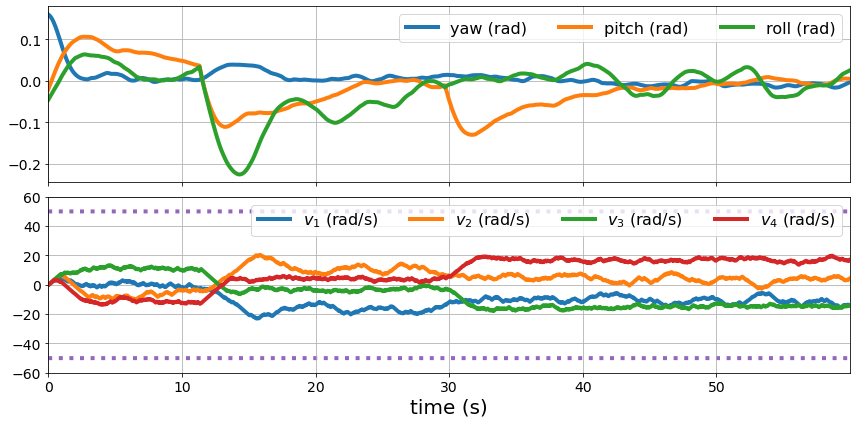

In [84]:
controller = Controller()
######
# simulator.reset(
#     orientation={
#         'yaw': 0.,
#         'pitch': 0.,
#         'roll': 0.,
#     },
#     angular_velocity={
#         'x': 0.,
#         'y': 0.,
#         'z': 0.,
#     },
#     scope_noise=0.1,
# )

simulator.reset(
    orientation=None,
    angular_velocity=None,
    scope_noise=0.1,
)
########
controller.reset()
########
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=60.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)
#########
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_rwvel) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=4)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=4)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

# # Plot x, y, z components of angular velocity
# ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
# ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
# ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
# ax_vel.grid()
# ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
# ax_vel.tick_params(labelsize=14)

# # Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['front_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['back_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['left_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['right_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# # Plot torque applied to each reaction wheel
# ax_rwtau.plot(data['t'], data['front_torque'], label=r'$\tau_1$ (N-m)', linewidth=4)
# ax_rwtau.plot(data['t'], data['back_torque'], label=r'$\tau_2$ (N-m)', linewidth=4)
# ax_rwtau.plot(data['t'], data['left_torque'], label=r'$\tau_3$ (N-m)', linewidth=4)
# ax_rwtau.plot(data['t'], data['right_torque'], label=r'$\tau_4$ (N-m)', linewidth=4)
# ax_rwtau.plot(
#     data['t'], np.ones_like(data['t']) * simulator.tau_max,
#     ':', linewidth=4, color='C4', zorder=0,
# )
# ax_rwtau.plot(
#     data['t'], -np.ones_like(data['t']) * simulator.tau_max,
#     ':', linewidth=4, color='C4', zorder=0,
# )
# ax_rwtau.grid()
# ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
# ax_rwtau.tick_params(labelsize=14)


# # Set x-axis properties (only need to do this on the last
# # subplot since all subplots share the same x-axis)
ax_rwvel.set_xlabel('time (s)', fontsize=20)
ax_rwvel.set_xlim([data['t'][0], data['t'][-1]])
# ax_rwvel.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()
##########

# 100 Simulations

In [96]:
data.keys()

dict_keys(['t', 'yaw', 'pitch', 'roll', 'w_x', 'w_y', 'w_z', 'front_torque', 'back_torque', 'left_torque', 'right_torque', 'front_torque_command', 'back_torque_command', 'left_torque_command', 'right_torque_command', 'front_velocity', 'back_velocity', 'left_velocity', 'right_velocity', 'star_meas', 'xhat'])

In [101]:
testyaw = [1,2,3]
testpitch = [4,5,6]
np.array([testyaw,testpitch]).T

array([[1, 4],
       [2, 5],
       [3, 6]])

In [99]:
# y_actual = data['star_meas']
y_predicted = data['xhat']
y_actual = np.array([data['yaw'],data['pitch'],data['roll'],data['w_x'],data['w_y'],data['w_z']])
MSE = np.square(y_actual.T - y_predicted).mean()
RMSE = np.sqrt(MSE)
print(RMSE)

0.030770172837952393


In [78]:
def run_simulation():
    controller = Controller()
    simulator.reset(
        orientation=None,
        angular_velocity=None,
        scope_noise=0.1,
    )
    ########
    controller.reset()
    ########
    data = simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=65.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
        print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
    )
    t = data['t'][-1]
    if t < .5:
        return False
    else:
        yaw = data['yaw'][0]
        pitch = data['pitch'][0]
        roll = data['roll'][0]
        return t,yaw,pitch,roll

i = 1000
times = []
bad_times = []
initial_yaws = []
initial_pitches = []
initial_rolls = []
while i > 0:
    sim_data = run_simulation()
    if sim_data == False:
        i = i-1
    else:
        times.append(sim_data[0])
        initial_yaws.append(sim_data[1])
        initial_pitches.append(sim_data[2]) 
        initial_rolls.append(sim_data[3])
        i = i-1
    
        

print(len(times))
# good_times = times[(times >= 15.0)]
# len(good_times)

908


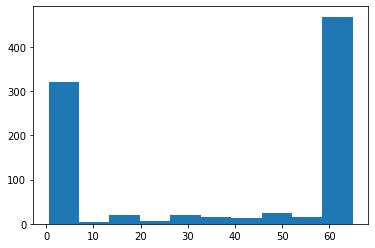

In [79]:
plt.hist(times)
plt.show()
#print(times)
good_times = [i for idx, i in enumerate(times) if times[idx] >= 60]
len(good_times)/len(times)

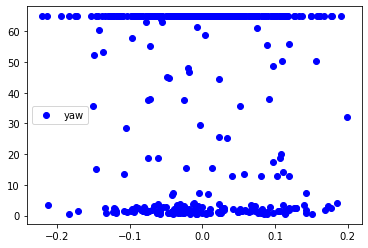

In [77]:
plt.scatter(initial_yaws,times, color = 'blue', label = 'yaw')

plt.legend()

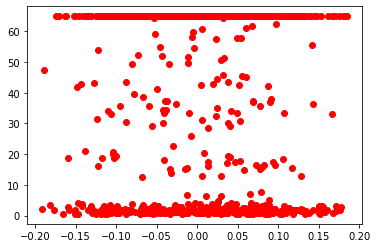

In [68]:
plt.scatter(initial_pitches,times,color = 'red', label = 'pitch')

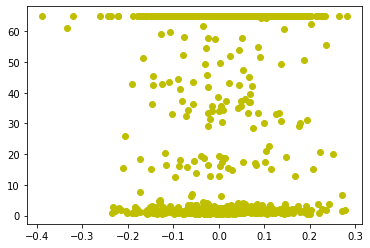

In [69]:
plt.scatter(initial_rolls,times,color = 'y', label = 'roll')

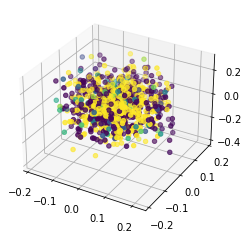

In [70]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(initial_yaws, initial_pitches, initial_rolls, c=times)

Create an instance of the controller.

In [28]:
controller = Controller()

In [29]:
import random 
random.randrange(-.5,.5)

/var/folders/r_/l306ffw14t12khw6vmzm9vcr0000gn/T/ipykernel_48124/1444708970.py:2: DeprecationWarning: randrange() will raise TypeError in the future
  random.randrange(-.5,.5)


ValueError: non-integer arg 1 for randrange()

You could reset the simulator with given initial conditions, optionally specifying scope noise (default is `0.1`), i.e., the standard deviation of the $y$ and $z$ components of each star tracker measurement.

In [ ]:
simulator.reset(
    orientation={
        'yaw': 0.,
        'pitch': 0.,
        'roll': 0.,
    },
    angular_velocity={
        'x': 0.,
        'y': 0.,
        'z': 0.,
    },
    scope_noise=0.1,
)

Or, you could reset the simulator with initial conditions sampled at random.

In [ ]:
simulator.reset(
    orientation=None,
    angular_velocity=None,
    scope_noise=0.1,
)

Reset the controller.

In [ ]:
controller.reset()

Run the simulator. It will quit when one of the following conditions is satisfied:

* Any star goes out of view of the scope.
* Any reaction wheel has angular velocity exceeding +/- 50 rad/s.
* The maximum time is reached.

In [ ]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=60.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    print_debug=False,    # <-- optional (whether to print debug text - this is recommended when saving video)
)

Get, show, and save a snapshot of the simulation after the last time step.

In [ ]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

In [ ]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_ori, ax_vel, ax_rwvel, ax_rwtau) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# Plot yaw, pitch, roll angles
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=4)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=4)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=16, ncol=3, loc='upper right')
ax_ori.tick_params(labelsize=14)

# Plot x, y, z components of angular velocity
ax_vel.plot(data['t'], data['w_x'], label=r'$w_x$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_y'], label=r'$w_y$ (rad/s)', linewidth=4)
ax_vel.plot(data['t'], data['w_z'], label=r'$w_z$ (rad/s)', linewidth=4)
ax_vel.grid()
ax_vel.legend(fontsize=16, ncol=3, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot angular velocity of each reaction wheel
ax_rwvel.plot(data['t'], data['front_velocity'], label=r'$v_1$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['back_velocity'], label=r'$v_2$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['left_velocity'], label=r'$v_3$ (rad/s)', linewidth=4)
ax_rwvel.plot(data['t'], data['right_velocity'], label=r'$v_4$ (rad/s)', linewidth=4)
ax_rwvel.plot(
    data['t'], np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.plot(
    data['t'], -np.ones_like(data['t']) * simulator.v_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwvel.grid()
ax_rwvel.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwvel.tick_params(labelsize=14)
ax_rwvel.set_ylim(-1.2 * simulator.v_max, 1.2 * simulator.v_max)

# Plot torque applied to each reaction wheel
ax_rwtau.plot(data['t'], data['front_torque'], label=r'$\tau_1$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['back_torque'], label=r'$\tau_2$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['left_torque'], label=r'$\tau_3$ (N-m)', linewidth=4)
ax_rwtau.plot(data['t'], data['right_torque'], label=r'$\tau_4$ (N-m)', linewidth=4)
ax_rwtau.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_rwtau.grid()
ax_rwtau.legend(fontsize=16, ncol=4, loc='upper right')
ax_rwtau.tick_params(labelsize=14)


# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_rwtau.set_xlabel('time (s)', fontsize=20)
ax_rwtau.set_xlim([data['t'][0], data['t'][-1]])
ax_rwtau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [ ]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot star positions in image. This is not necessarily a useful thing to plot. The point is to show how to access measurements of star position from logged data.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
for i in range(len(simulator.stars)):
    y = data['star_meas'][:, 2 * i]
    z = data['star_meas'][:, 2 * i + 1]
    ax.plot(-y, z, label=f'star {i}', linewidth=0.5, marker='.', markersize=10)
ax.grid()
ax.legend(fontsize=16)
ax.tick_params(labelsize=14)
ax.set_xlim(-1., 1.)
ax.set_ylim(-1., 1.)